In [ ]:
import numpy as np
import matplotlib.pyplot as plt

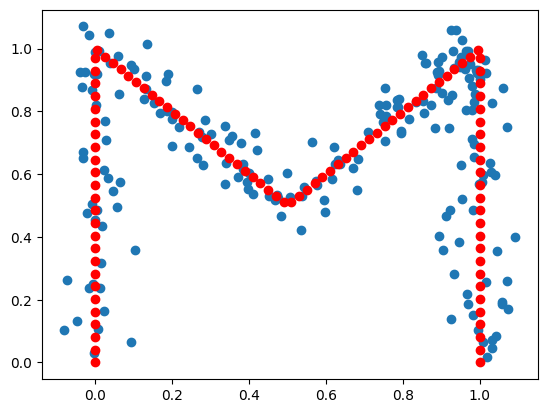

In [ ]:
np.random.seed(20)

#Defino g

def g(u):
  if u >= 0 and u < 0.25:
    return np.array([0, 4*u])
  if u >= 0.25 and u < 0.5:
    return np.array([2*u - 0.5, 1.5 - 2*u])
  if u >= 0.5 and u < 0.75:
    return np.array([2*u - 0.5, 2*u - 0.5])
  else:
    return np.array([1, 4 - 4*u])

#Creo mi vector de uniformes y aplico U
U = np.random.uniform(0, 1, 200)
G = np.array([g(u) for u in U])

Z = np.random.normal(0, 1, size=[200, 2])

#Añado el ruido
X = G + 0.05*Z

#Manifold
t = np.linspace(0, 1, 100)
M = np.array([g(t) for t in t])

plt.scatter(X[:,0], X[:,1])
plt.scatter(M[:,0], M[:,1], color="r")

##K-means

El algoritmo K-means consiste en tomar clusters a partir de la distancia de los datos a ciertos centroides. Estos son inicializados seleccionando muestras aleatorias.

El algoritmo consiste en asignar las muestras a su respectivo cluster, una muestra pertenecerá al cluster con el centroide más cercano a ella. Una vez separadas las muestras por cluster, se calcula la media de cada set y se actualizan los centroides a partir de esas medias.

Se considera que el algoritmo converge cuando la diferencia entre los centroides de un paso al siguiente es lo suficientemente pequeña.

In [ ]:
class KMeans:
    def __init__(self, n_clusters, cvg=1e-8):
        self.n_clusters = n_clusters #Defino la cant de clusters
        self.cvg = cvg  #Criterio de convergencia
        self.centroides = None

    def fit(self, X):

        indices = np.random.choice(len(X), self.n_clusters, replace=False) #Elijo inidices aleatorios para inicializar los centroides
        self.centroides = X[indices]

        shift = self.cvg + 10 #Arranco con un shift alto

        while  shift > self.cvg:
            # Hago un predict para asignarle un cluster a cada muestra
            labels = self.predict(X)

            #Calculo los nuevos centroides con la media
            centroides = np.array([
                X[labels == k].mean(axis=0) for k in range(self.n_clusters)
            ])

            shift = np.linalg.norm(centroides - self.centroides) #Verifico si converge al ver el cambio de posicion de los centroides

            self.centroides = centroides #Reasigno

    def predict(self, X):
        #Calculo distancias
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroides, axis=2)
        #Tomo la minima
        return np.argmin(distances, axis=1)


###Aplicación del algoritmo k-means

Se observa que el algoritmo k-means no logra una separación de los clusters muy buena (no tenemos que cada lado de la M es un cluster). Esto es esperable dado la simpleza con la que k-means trata los datos, que podría explicarse como una mezcla de gaussianas pero con covarianza esférica.

Esta simplificación de la forma que toman los clusters hace que sea imposible que el algoritmo converja como es esperado, salvo en casos muy concretos donde la inicialización aleatoria es favorable.

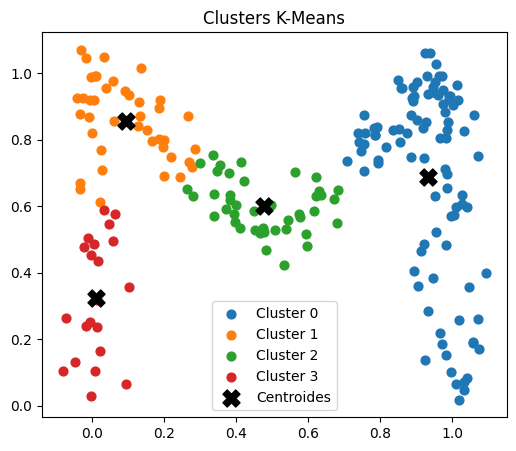

In [ ]:
kmeans = KMeans(n_clusters = 4, cvg = 1e-20) #Elijo 4 clusters por cada linea de la M

kmeans.fit(X)

labels = kmeans.predict(X) #Tomo labels y centroides para graficar
centroides = kmeans.centroides

plt.figure(figsize=(6, 5))
for i in range(kmeans.n_clusters):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=40, label=f'Cluster {i}')

plt.scatter(centroides[:, 0], centroides[:, 1], c='black', s=150, marker='X', label='Centroides')

plt.legend()
plt.title("Clusters K-Means")
plt.show()

##EM para mezcla de gaussianas

Comenzamos suponiendo que la distribución de nuestras muestras es una mezcla de gaussianas.

$$p(x) = \sum_{k=1}^{K} c_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)$$

El algoritmo consta de dos pasos:

###Expectación

Se calcula la probabilidad de pertenencia de una muestra a cada uno de los K clusters. El evento $z_n = k$ indica la pertenencia de $x_n$ al cluster $k$.

$$q_k = P(z_n = k \mid x_n, c_k ,\mu_k, \Sigma_k) =
\frac{c_k \, \mathcal{N}(x_n \mid \mu_k, \Sigma_k)}
{\sum_{j=1}^{K} c_j \, \mathcal{N}(x_n \mid \mu_j, \Sigma_j)}$$

Este paso también sirve como predicción soft ya que nos dice la probabilidad de que la muestra pertenezca a cada uno de los clusters. Tomar el cluster con la max proba sería hacer la predicción hard.

###Maximización

Se busca maximizar la función de costo

$$J = \sum_{n=1}^N \sum_{k=1}^K q_{n,k}\,\log({p(x_n\mid c_k, \mu_k, \Sigma_k)})$$

bajo la condición de que la sumatoria sobre los $c_k$ sea unitaria.

De esa maximización salen los siguientes pasos de actualización:

$$N_k = \sum_{n = 1}^N q_{n,k}$$

$$c_k = N_k/N$$

$$\mu_k = \frac{\sum_{n = 1}^N q_{n,k}\,x_n}{N_k}$$

$$\Sigma_k = \frac{\sum_{n = 1}^N q_{n,k}\,(x_n - \mu_k)(x_n - \mu_k)^T}{N_k}$$


Si se quiere analizar de manera intuitiva, podría verse como que la influencia de cada muestra en la actualización de los parámetros de cada cluster está pesada por la probabilidad de que esa muestra pertenezca a ese cluster. Puede verse que el k-means hace algo parecido para el calculo de centroides, ya que pesa por 1 a las muestras que pertenecen al cluster y 0 a las que no.

Como criterio de convergencia se utiliza la log-verosimilitud total, el algoritmo se detiene cuando deja de cambiar significativamente.

$$\mathcal{L}(\Theta) = \sum_{n=1}^{N} \log\left(\sum_{k=1}^{K} c_k \, \mathcal{N}(x_n \mid \mu_k, \Sigma_k)\right)$$


Para mejorar la velocidad de convergencia y facilitar que los clusters se generen donde son esperados, el algoritmo es inicializado con un k-means.



In [ ]:
class EM:
    def __init__(self, n_components=4, cvg=1e-4):
        self.n_components = n_components # La cantidad de gaussianas a estimar
        self.cvg = cvg #Limite de convergencia
        self.means_ = None
        self.covs = None
        self.c = None

    #Pdf de gaussiana para los calculos
    def gauss(self, X, mean, cov):
        n = X.shape[1]
        diff = X - mean
        inv_cov = np.linalg.inv(cov)
        norm_const = 1.0 / np.sqrt(((2 * np.pi) ** n) * np.linalg.det(cov))
        exp_term = np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))
        return norm_const * exp_term

    def fit(self, X):
        N, D = X.shape

        #Uso un algoritmo kmeans para inicializar la media y varianza de cada cluster
        kmeans = KMeans(n_clusters = self.n_components, cvg = 1e-15)
        kmeans.fit(X)
        self.means = kmeans.centroides
        labels = kmeans.predict(X)
        self.covs = np.array([np.cov(X[labels == k].T) for k in range(self.n_components)])
        self.c = np.ones(self.n_components) / self.n_components #Inicializo los pesos uniformes

        #Arranco con unadiferencia grande de verosimilitud
        log_ver = 10
        log_ver_old = 0

        while np.abs(log_ver - log_ver_old) > self.cvg:
            #Expectación
            q = np.zeros((N, self.n_components)) #Vector donde almacenar las probas de cada muestra de estar en cada cluster
            for k in range(self.n_components):
                q[:, k] = self.c[k] * self.gauss(X, self.means[k], self.covs[k]) #Calculo con la pdf para cada cluster con su respectivo peso
            q /= np.sum(q, axis=1, keepdims=True) #Normalizo

            #Maximizacion
            Nk = np.sum(q, axis=0)
            self.c = Nk / N #Calculo los nuevos pesos
            self.means = (q.T @ X) / Nk[:, np.newaxis] #Nuevas medias
            self.covs = np.zeros((self.n_components, D, D)) #Nuevas covs
            for k in range(self.n_components):
                diff = X - self.means[k]
                self.covs[k] = (q[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]

            #Evaluo como esta cambiando la log verosimilitud
            p = np.zeros((N, self.n_components))
            for k in range(self.n_components):
                p[:,k] = self.c[k] * self.gauss(X, self.means[k], self.covs[k])
            log_ver_old = log_ver
            log_ver = np.sum(np.log(np.sum(p, axis=1)), axis=0)

    def predict_proba(self, X):
        #Calculo la proba de que cada muestra pertenezca a cada cluster
        p = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            p[:,k] = self.c[k] * self.gauss(X, self.means[k], self.covs[k])
        return p


    def predict(self, X):
        #Hago el argmax del soft predict
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)


### Aplicacion del algoritmo em

Se observa una clara mejoría en la clasificación por clusters con respecto al k-means. Los lados parecen identificarse mejor ahora que el algoritmo tiene en cuenta una covarianza en la distribución de cada cluster. Al mismo tiempo, se mejoraron las ubicaciones de los centroides, que estan más al medio de cada uno de los lados.

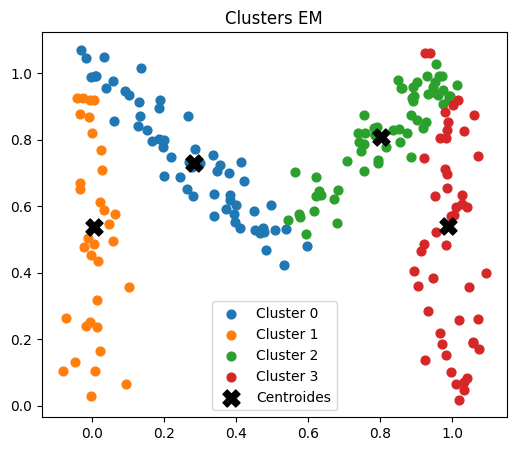

In [ ]:
em = EM(n_components = 4, cvg=1e-10)

em.fit(X)

labels = em.predict(X)
centroids = em.means

plt.figure(figsize=(6, 5))
for i in range(em.n_components):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], s=40, label=f'Cluster {i}')

# Dibujar los centroides
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=150, marker='X', label='Centroides')

plt.legend()
plt.title("Clusters EM")
plt.show()

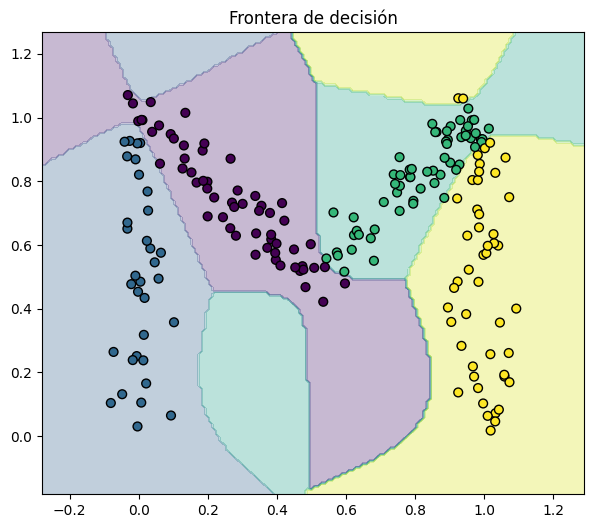

In [ ]:
#Creo un mesh para ver las fronteras de decision
margen = 0.2
h = 0.01
x_min, x_max = X[:, 0].min() - margen, X[:, 0].max() + margen
y_min, y_max = X[:, 1].min() - margen, X[:, 1].max() + margen
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

puntos = np.c_[xx.ravel(), yy.ravel()]
Z = em.predict(puntos)
Z = Z.reshape(xx.shape)

# Graficar contorno y puntos
plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c=em.predict(X), s=40, cmap='viridis', edgecolor='k')
plt.title("Frontera de decisión")
plt.show()


### PCA

PCA nos va a permitir disminuir la dimensionalidad de las muestras, proyectándolas al eje principal. En este caso es de utilidad ya que nos va a permitir representar el manifold de los datos, haciendo un PCA por cada cluster que proyecte las muestras que pertenecen a él a su eje principal. Se observa que tomando la maxima y minima proyeccion en cada cluster puede formarse una línea que represente el eje principal.

In [ ]:
class PCA():
  def __init__(self):
    self.avas = None
    self.avcs = None
    self.mean = None
    self.std = None
    self.max_proy = None #Guardo maximos y minimos de la proyeccion
    self.min_proy = None

  def fit(self, X):
    #Normalizo en media
    self.mean = X.mean(axis=0)
    X_norm = (X - self.mean)

    #Obtengo la matriz de covarianza
    cov = np.cov(X_norm.T)
    self.avas, self.avcs = np.linalg.eig(cov) #Saco los avas
    idx = np.argsort(self.avas) #Ordeno de mayo a menor
    idx = idx[::-1]
    self.avas = self.avas[idx]
    self.avcs = self.avcs[:, idx]



  def transform(self, X, n_components):
    X_norm = (X - self.mean) #Normalizacion en media
    proyection = self.avcs[:, :n_components].T @ X_norm.T #Proyecto a los n mayores avas
    self.max_proy = proyection.max() #Guardo los maximos y minimos
    self.min_proy = proyection.min()
    return proyection.T

  def inverse_transform(self, X):
    dim = X.shape[1]
    inverse = self.avcs[:, :dim] @ X.T #Anti transformo con los avcs
    return self.mean + inverse.T #Sumo la media

  def fit_transform(self, X, n_components):
    self.fit(X)
    return self.transform(X, n_components)




###Reconstrucción del manifold

Separando los datos en sus respectivos clusters y proyectando, se pueden conseguir las rectas en las direcciones principales de cada cluster. Limitando por las proyecciones minimas y maximas, se observa la similitud con la M.

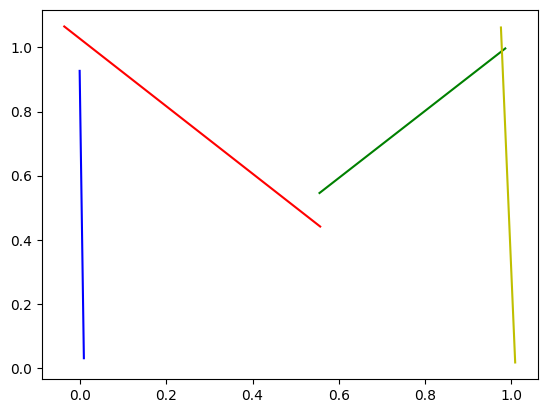

In [ ]:
#Separacion por clusters
X_1 = X[labels == 0]
X_2 = X[labels == 1]
X_3 = X[labels == 2]
X_4 = X[labels == 3]

#Entreno y transformo con un pca por cluster
pca1 = PCA()
pca2 = PCA()
pca3 = PCA()
pca4 = PCA()

proy_1 = pca1.fit_transform(X_1, 1)
proy_2 = pca2.fit_transform(X_2, 1)
proy_3 = pca3.fit_transform(X_3, 1)
proy_4 = pca4.fit_transform(X_4, 1)

#Guardo los extremos de cada pca
extremos_pca1 = np.array([[pca1.max_proy, pca1.min_proy]]).T
extremos_pca2 = np.array([[pca2.max_proy, pca2.min_proy]]).T
extremos_pca3 = np.array([[pca3.max_proy, pca3.min_proy]]).T
extremos_pca4 = np.array([[pca4.max_proy, pca4.min_proy]]).T

#Antitransformo para ubicarlos en el espacio 2d
inv_extremos1 = pca1.inverse_transform(extremos_pca1)
inv_extremos2 = pca2.inverse_transform(extremos_pca2)
inv_extremos3 = pca3.inverse_transform(extremos_pca3)
inv_extremos4 = pca4.inverse_transform(extremos_pca4)

#Ploteo
plt.figure()
plt.plot(inv_extremos1[:,0], inv_extremos1[:,1], color="r")
plt.plot(inv_extremos2[:,0], inv_extremos2[:,1], color="b")
plt.plot(inv_extremos3[:,0], inv_extremos3[:,1], color="g")
plt.plot(inv_extremos4[:,0], inv_extremos4[:,1], color="y")

## Detección de anomalías

El algoritmo PCA junto con el clusterizador EM puede ser útil para detectar anomalías. Particularmente puede calcularse la distancia entre una muestra y la proyección a al eje principal de su correspondiente cluster. Si esa distancia supera cierto umbral, puede tomarse como un punto anómalo.

Se ve que con esta primera aproximación no hay tan buena detección, ya que las muestras que cumplen esta condición se extienden a lo largo de todo el eje principal del cluster.

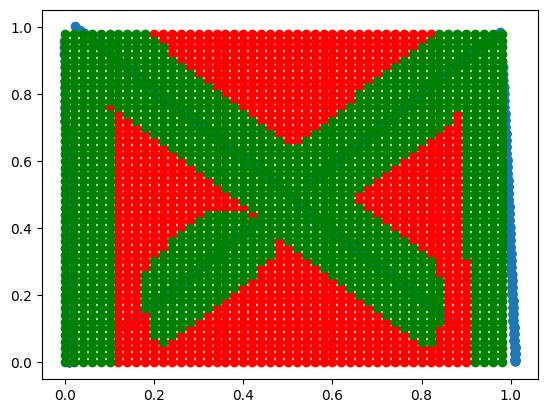

In [ ]:
#Creo el mesh
h = 0.02
x_min, x_max = 0, 1
y_min, y_max = 0, 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

Z = np.c_[xx.ravel(), yy.ravel()]

#Etiqueto
labels = em.predict(Z)


#Separo en clusters como antes y proyecto cada un con el pca entrenado:
Z_1 = Z[labels == 0]
Z_2 = Z[labels == 1]
Z_3 = Z[labels == 2]
Z_4 = Z[labels == 3]

proy1 = pca1.transform(Z_1, 1)
proy2 = pca2.transform(Z_2, 1)
proy3 = pca3.transform(Z_3, 1)
proy4 = pca4.transform(Z_4, 1)

#Antitransformo mis proyecciones
unproy1 = pca1.inverse_transform(proy1)
unproy2 = pca2.inverse_transform(proy2)
unproy3 = pca3.inverse_transform(proy3)
unproy4 = pca4.inverse_transform(proy4)

#Creo vectores con los que voy a determinar anomalías
unproy = np.vstack((unproy1, unproy2, unproy3, unproy4))
Z = np.vstack((Z_1, Z_2, Z_3, Z_4))

umbral = 0.01

#Como primera aproximación veo la distancia de cada punto a su proyección, si supera cierto umbral es anomalo
dist2 = np.sum((Z - unproy)**2, axis=1)
Z_anomalo = Z[dist2 > umbral]
Z_normal  = Z[dist2 <= umbral]


plt.figure()
plt.scatter(unproy[:,0], unproy[:,1])
plt.scatter(Z_anomalo[:,0], Z_anomalo[:,1], color="r")
plt.scatter(Z_normal[:,0], Z_normal[:,1], color="g")







 Como segunda aproximación se plantea tambien tomar como anormales a aquellos puntos cuya proyección da por fuera de los maximos y minimos obtenidos con los datos de entrenamiento. Se puede observar que el resultado es mejor.

[False False False ...  True  True  True]


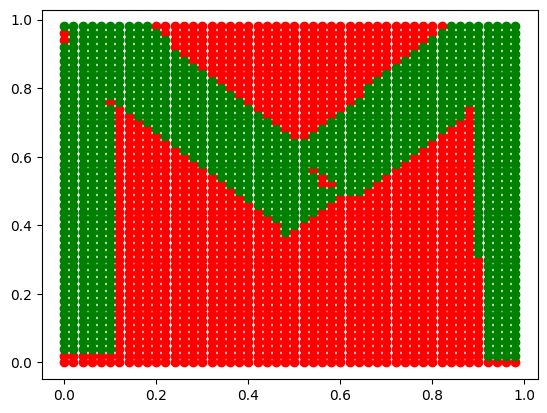

In [ ]:
#Armo una mascara para determinar si la proyeccion esta dentro del respectivo cluster
mask1 = (proy1 <= extremos_pca1[0,:]) & (proy1 >= extremos_pca1[1,:])
mask2 = (proy2 <= extremos_pca2[0,:]) & (proy2 >= extremos_pca2[1,:])
mask3 = (proy3 <= extremos_pca3[0,:]) & (proy3 >= extremos_pca3[1,:])
mask4 = (proy4 <= extremos_pca4[0,:]) & (proy4 >= extremos_pca4[1,:])

mask = np.vstack((mask1, mask2, mask3, mask4))

#Añado la mascara calculada antes, si la proyeccion no cayó dentro de los limites del cluster, el punto tambien es anomalo
cond_normal = (dist2 <= umbral) & mask[:,0]
print(mask[:,0])

Z_normal = Z[cond_normal]
Z_anomalo = Z[~cond_normal]

plt.figure()
plt.scatter(Z_anomalo[:,0], Z_anomalo[:,1], color="r")
plt.scatter(Z_normal[:,0], Z_normal[:,1], color="g")